# Digit Recognition System — End‑to‑End Project Plan (Notebook Roadmap)
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade


> **Purpose:** Build a production‑ready system that classifies handwritten digits (0–9) from 28×28 grayscale images provided as flattened features `pixel0` … `pixel783`, with an optional `label` column in the training data. This roadmap explains the full lifecycle—from data intake to deployment and monitoring—so every subsequent cell in this notebook can be traced to a clear objective.

---

## 1) Objectives & Success Criteria
- **Primary Task:** Multiclass classification of digits (0–9).
- **KPIs:** Overall Accuracy; macro Precision/Recall/F1; per‑class F1; inference latency (ms); throughput (req/s).
- **Acceptance Targets (example):** ≥99% validation accuracy with stable per‑class performance; p95 latency < 20 ms on target hardware.
- **Deliverables:** Trained model artifact, reproducible training/eval pipeline, REST/Batch inference service, model card, monitoring dashboard.

## 2) Governance, Compliance & Reproducibility
- **Data Handling:** Document provenance; maintain a *Datasheet for Datasets*; handle PII (not expected here) according to policy.
- **Experiment Tracking:** Use MLflow/W&B to log code version, data hash, params, metrics, and artifacts for audit trails.
- **Determinism:** Set seeds; pin library versions; capture environment (conda/requirements + hardware notes).
- **Documentation:** Maintain a Model Card summarizing intended use, limitations, metrics, and evaluation protocols.

## 3) Data Description & Intake
- **Columns:** `label` (train only), `pixel0` … `pixel783` (784 grayscale intensities, typically 0–255). 
- **Shapes:** Each sample is 28×28 after reshaping; channel=1 (grayscale).
- **Integrity Checks:** Missing/constant columns, duplicate rows, invalid ranges, label coverage (0–9).

## 4) Exploratory Data Analysis (EDA)
- Class distribution, sample gallery, mean/variance images per class.
- Dimensionality reduction (PCA/UMAP) for structure visualization.
- Pixel intensity histograms; correlation/variance to spot redundant or dead pixels.
- Baseline difficulty analysis via confusion tendencies.

## 5) Data Preprocessing
- **Normalization:** Scale pixels to [0, 1] or standardize.
- **Reshape:** `(n, 28, 28, 1)` for CNNs; keep `(n, 784)` for linear baselines.
- **Stratified Split:** Train/validation (e.g., 80/20).
- **Augmentation (optional):** Small rotations, shifts, elastic distortion to improve robustness.
- **Label Encoding:** One‑hot for neural nets when needed.

## 6) Baseline Models (for quick benchmarks)
- Logistic Regression / Linear SVM on `(n, 784)`.
- Random Forest / LightGBM as non‑deep baselines.
- Record metrics & confusion matrix; retain the best baseline as a fallback model.

## 7) Production‑Grade Model (CNN)
- **Starter Architecture:** (Conv→BN→ReLU→Pool)×2–3 + Dense head with dropout.
- **Training:** Cross‑entropy loss; Adam or SGD + cosine/step LR schedule; early stopping; model checkpointing.
- **Regularization:** Dropout, L2, data augmentation, mixup/cutmix (optional).
- **Calibration:** Temperature scaling or Platt scaling if calibrated probabilities are required.

## 8) Hyperparameter Optimization
- Search ranges for LR, batch size, filters, kernel sizes, dropout rates, augmentation strength, epochs.
- Use Random/Bayesian search; track all trials in MLflow/W&B.
- Select the best model by validation macro‑F1 and stability across random seeds.

## 9) Evaluation & Robustness
- **Reports:** Accuracy; macro/micro Precision/Recall/F1; per‑class metrics; confusion matrix.
- **Stress Tests:** Noise, small rotations, contrast changes; assess performance deltas.
- **Statistical Confidence:** Bootstrap confidence intervals for headline metrics.
- **Fairness/Balance:** Inspect per‑class disparities and error modes; document mitigations.

## 10) Explainability
- **Global:** Feature/region importance summaries; filter/activation inspection.
- **Local:** Saliency/Grad‑CAM on correctly and incorrectly classified samples.
- **Human Review Set:** Curate edge cases for qualitative assessment and sign‑off.

## 11) Packaging & Deployment
- **Artifacts:** SavedModel/TorchScript/ONNX; versioned with metadata (schema, metrics, commit hash).
- **Interfaces:** Batch (parquet/CSV) and/or Online (FastAPI/Flask) with input schema validation.
- **Performance:** Measure cold/warm start, p95 latency, and throughput on target hardware.
- **Security:** Input validation, size/type checks, rate limiting; structured logging.

## 12) Monitoring & MLOps
- **In Production:** Track accuracy proxies, class distribution shifts, drift (data/label), service health metrics.
- **Retraining Loop:** Triggered by drift/quality thresholds; A/B or shadow deployments for safe rollouts.
- **Incident Response:** Playbook for degradations; rollback strategy; postmortems.

## 13) Project Structure (proposed)
```
digit-recognition/
├─ data/                 # raw/processed (symlink or DVC tracked)
├─ notebooks/            # this notebook + experiments
├─ src/
│  ├─ data.py            # loading, validation, splits
│  ├─ features.py        # transforms, augmentation
│  ├─ models/            # baselines + CNN
│  ├─ train.py           # training loop
│  ├─ evaluate.py        # metrics & reports
│  ├─ infer_api.py       # FastAPI app
│  └─ utils.py           # seeds, config, logging
├─ configs/              # YAML for hyperparams & paths
├─ requirements.txt / environment.yml
├─ model_card.md
└─ README.md
```

## 14) Next Cells (Execution Plan)
1. **Environment & Reproducibility Setup** (seeds, imports, versions, MLflow init).
2. **Load & Validate Data** (schema checks; sanity visuals).
3. **EDA** (distribution/visuals; PCA/UMAP).
4. **Preprocessing Pipeline** (normalize, reshape, stratified split, augmentation).
5. **Baselines** (train/evaluate; log metrics).
6. **CNN Training** (checkpoint, early stop; logs).
7. **HPO** (search + best model selection).
8. **Evaluation Suite** (reports, robustness tests, CIs).
9. **Explainability** (saliency/Grad‑CAM).
10. **Export & Package** (ONNX/SavedModel + signatures).
11. **Inference Service** (FastAPI; schema validation).
12. **Monitoring Hooks & Model Card** (export artifacts).

---


In [1]:
# Environment Setup & Reproducibility

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf

# 1. Force CPU-only usage (disable GPU if present)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# 2. Reproducibility: set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 3. Print versions (for full reproducibility log)
print("Python libraries versioning:")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"TensorFlow: {tf.__version__}")

# Confirm device being used
print("\nAvailable devices:", tf.config.list_physical_devices())


C:\Users\AKINMADE FARUQ\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\AKINMADE FARUQ\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\AKINMADE FARUQ\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid co

Python libraries versioning:
Numpy: 2.2.6
Pandas: 2.3.2
Matplotlib: 3.10.5
Seaborn: 0.13.2
Scikit-learn: 1.7.1
TensorFlow: 2.20.0

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Training Data Shape: (42000, 785)
Test Data Shape: (28000, 784)

Columns: ['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8'] ...

Missing values in training data: 0
Missing values in test data: 0

Label distribution:
label
1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: proportion, dtype: float64


C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_7464\2769350444.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=train_df, palette="viridis")


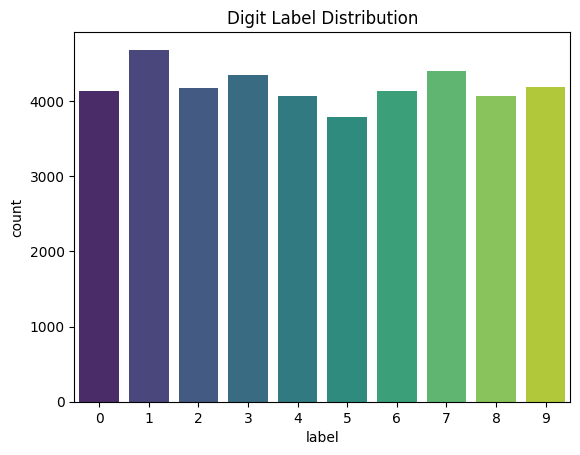

In [2]:
# Load & Inspect Data

# Adjust file paths as needed
train_path = "train.csv"
test_path = "test.csv"

# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Show basic info
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nColumns:", train_df.columns[:10].tolist(), "...")

# Check for missing values
print("\nMissing values in training data:", train_df.isnull().sum().sum())
print("Missing values in test data:", test_df.isnull().sum().sum())

# Inspect label distribution
if "label" in train_df.columns:
    print("\nLabel distribution:")
    print(train_df["label"].value_counts(normalize=True))
    sns.countplot(x="label", data=train_df, palette="viridis")
    plt.title("Digit Label Distribution")
    plt.show()


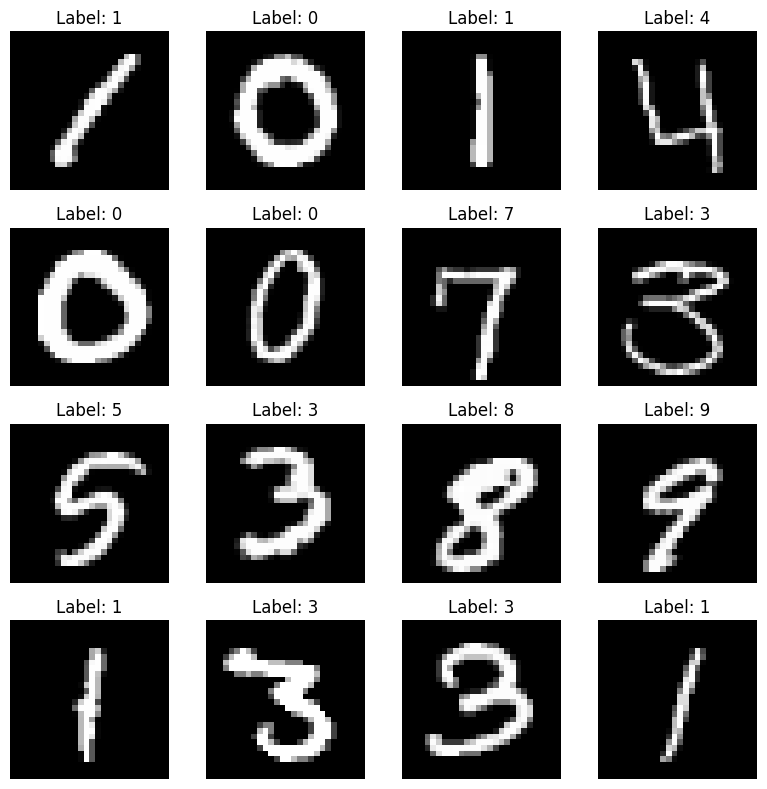

In [3]:
# Visualize Sample Digits from Training Data

# Function to plot a grid of digit images
def plot_digits(data, labels, n=16):
    plt.figure(figsize=(8, 8))
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        img = data.iloc[i, 1:].to_numpy().reshape(28, 28)  # skip label column
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {labels.iloc[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Plot first 16 images with labels
plot_digits(train_df, train_df["label"], n=16)


Sample digit images:


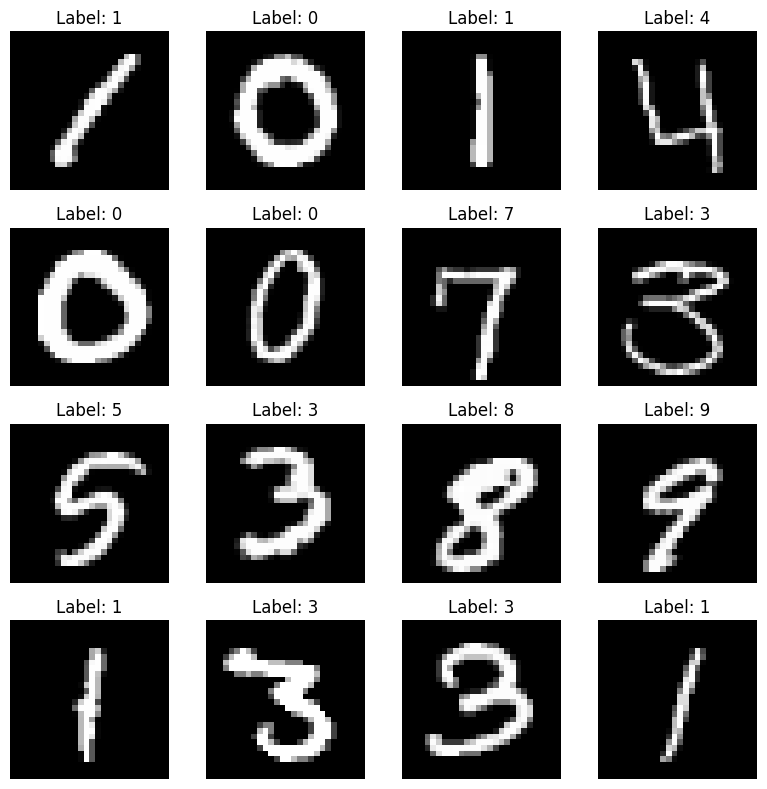

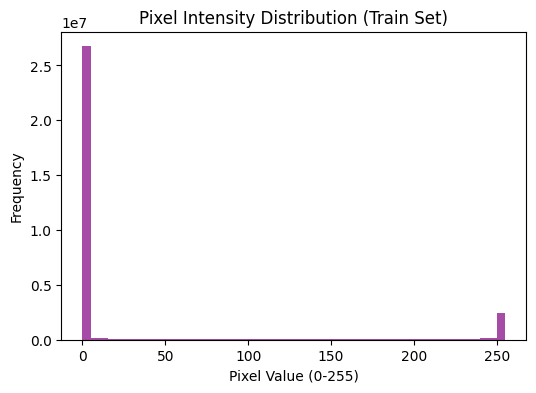

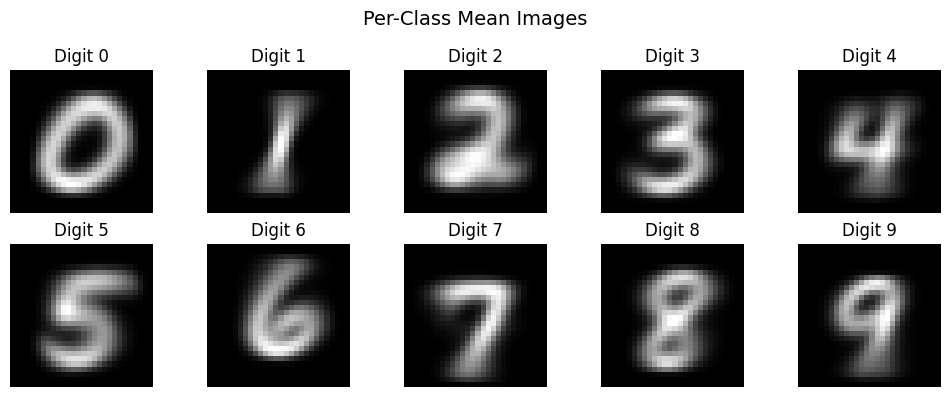

In [4]:
# Exploratory Data Analysis (EDA)

# 1. Visualize sample digits
def plot_digits(data, labels, n=16):
    plt.figure(figsize=(8, 8))
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        img = data.iloc[i, 1:].to_numpy().reshape(28, 28)
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {labels.iloc[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Sample digit images:")
plot_digits(train_df, train_df["label"], n=16)


# 2. Pixel intensity distribution
pixels = train_df.drop("label", axis=1).values.flatten()

plt.figure(figsize=(6, 4))
plt.hist(pixels, bins=50, color="purple", alpha=0.7)
plt.title("Pixel Intensity Distribution (Train Set)")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.show()


# 3. Mean images per digit class
mean_images = train_df.groupby("label").mean().to_numpy()

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mean_images[i].reshape(28, 28), cmap="gray")
    plt.title(f"Digit {i}")
    plt.axis("off")
plt.suptitle("Per-Class Mean Images", fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\AKINMADE FARUQ\AppData\Local\Temp\ipykernel_7464\2894488507.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=train_df, palette="coolwarm")


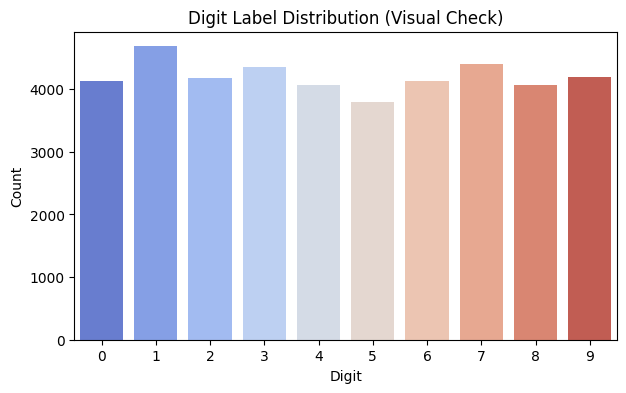

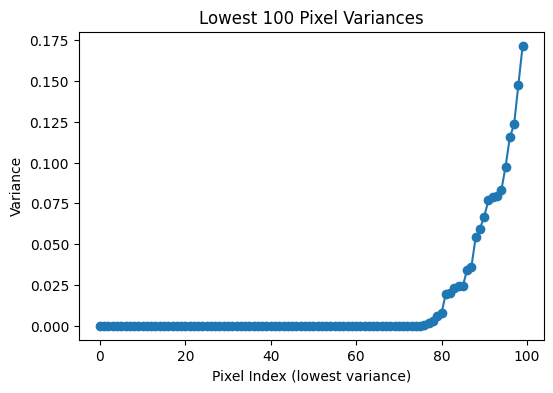

Number of near-constant pixels (variance < 1): 121


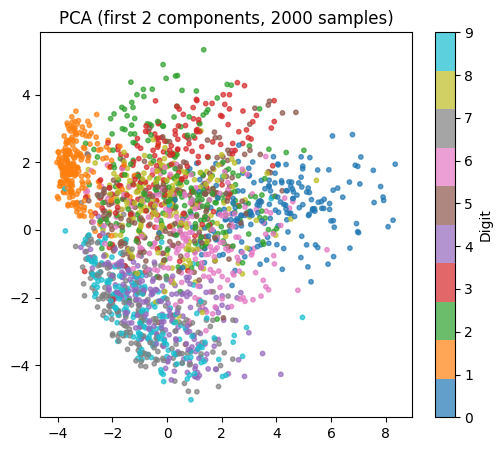

PCA explained variance (50 comps): 82.56%


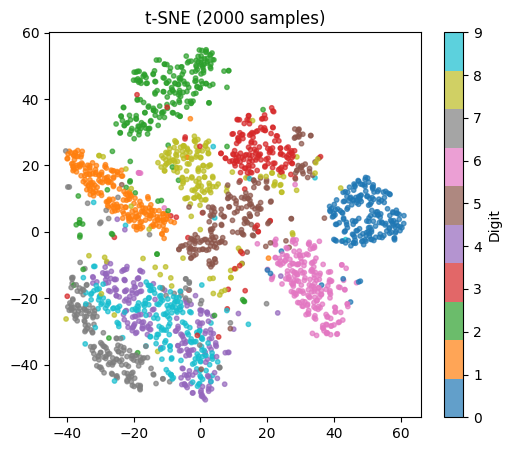

In [5]:
# Extended EDA 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1. Per-class counts visualization
plt.figure(figsize=(7, 4))
sns.countplot(x="label", data=train_df, palette="coolwarm")
plt.title("Digit Label Distribution (Visual Check)")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


# 2. Pixel variance across dataset (detect low-info pixels)
pixel_variances = train_df.drop("label", axis=1).var().sort_values(ascending=True)

plt.figure(figsize=(6, 4))
plt.plot(pixel_variances.values[:100], marker="o")
plt.title("Lowest 100 Pixel Variances")
plt.xlabel("Pixel Index (lowest variance)")
plt.ylabel("Variance")
plt.show()

print(f"Number of near-constant pixels (variance < 1): {(pixel_variances < 1).sum()}")


# 3. PCA projection (2D visualization)
X = train_df.drop("label", axis=1).values / 255.0  # normalize for PCA
y = train_df["label"].values

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:2000, 0], X_pca[:2000, 1], c=y[:2000], cmap="tab10", s=10, alpha=0.7)
plt.title("PCA (first 2 components, 2000 samples)")
plt.colorbar(label="Digit")
plt.show()

print(f"PCA explained variance (50 comps): {pca.explained_variance_ratio_.sum():.2%}")


# 4. t-SNE projection (slower, subset of data)
subset = 2000
X_subset = X[:subset]
y_subset = y[:subset]

# Fix: use max_iter instead of n_iter
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_subset)

plt.figure(figsize=(6, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap="tab10", s=10, alpha=0.7)
plt.title("t-SNE (2000 samples)")
plt.colorbar(label="Digit")
plt.show()


In [6]:
# Data Preprocessing

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 1. Separate features and labels
X = train_df.drop("label", axis=1).values
y = train_df["label"].values

# 2. Normalize pixel values to [0,1]
X = X.astype("float32") / 255.0

# 3. Reshape for CNN input: (samples, 28, 28, 1)
X = X.reshape(-1, 28, 28, 1)

# 4. One-hot encode labels for NN
y_cat = to_categorical(y, num_classes=10)

# 5. Stratified Train/Validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


X_train shape: (33600, 28, 28, 1)
X_val shape: (8400, 28, 28, 1)
y_train shape: (33600, 10)
y_val shape: (8400, 10)


In [7]:
# Baseline Models (Flattened Pixels)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Flatten images for classical ML
X_train_flat = X_train.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)

# 1. Logistic Regression
lr_model = LogisticRegression(max_iter=500, solver='saga', multi_class='multinomial', random_state=42, n_jobs=-1)
lr_model.fit(X_train_flat, y_train.argmax(axis=1))  # convert one-hot to labels
y_val_pred_lr = lr_model.predict(X_val_flat)

print("Logistic Regression Accuracy:", accuracy_score(y_val.argmax(axis=1), y_val_pred_lr))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_val.argmax(axis=1), y_val_pred_lr))

# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train_flat, y_train.argmax(axis=1))
y_val_pred_rf = rf_model.predict(X_val_flat)

print("Random Forest Accuracy:", accuracy_score(y_val.argmax(axis=1), y_val_pred_rf))
print("\nClassification Report (Random Forest):")
print(classification_report(y_val.argmax(axis=1), y_val_pred_rf))


C:\Users\AKINMADE FARUQ\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\AKINMADE FARUQ\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Accuracy: 0.9128571428571428

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       827
           1       0.93      0.98      0.95       937
           2       0.91      0.90      0.90       835
           3       0.90      0.88      0.89       870
           4       0.92      0.91      0.91       814
           5       0.87      0.86      0.86       759
           6       0.95      0.96      0.96       827
           7       0.93      0.93      0.93       880
           8       0.88      0.85      0.87       813
           9       0.88      0.90      0.89       838

    accuracy                           0.91      8400
   macro avg       0.91      0.91      0.91      8400
weighted avg       0.91      0.91      0.91      8400

Random Forest Accuracy: 0.9620238095238095

Classification Report (Random Forest):
              precision    recall  f1-score   support

        

In [8]:
# CNN Model Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Build CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# 2. Setup Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True)

# 3. Train the Model
history = cnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# 4. Evaluate on Validation Set
val_loss, val_acc = cnn_model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")


C:\Users\AKINMADE FARUQ\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 422,026 (1.61 MB)

 Trainable params: 421,834 (1.61 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8261 - loss: 0.6006 

525/525 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.9056 - loss: 0.3167 - val_accuracy: 0.9668 - val_loss: 0.1145
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9603 - loss: 0.1392 

525/525 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step - accuracy: 0.9642 - loss: 0.1249 - val_accuracy: 0.9829 - val_loss: 0.0614
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9708 - loss: 0.1009 

525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.9729 - loss: 0.0929 - val_accuracy: 0.9854 - val_loss: 0.0532
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.9768 - loss: 0.0759 - val_accuracy: 0.9857 - val_loss: 0.0595
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.9819 - loss: 0.0626 - val_accuracy: 0.9858 - val_loss: 0.0571
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.9829 - loss: 0.0592 - val_accuracy: 0.9868 - val_loss: 0.0575
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.9843 - loss: 0.0503 - val_accuracy: 0.9839 - val_loss: 0.0653
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.9870 - loss: 0.0438 - val_accuracy: 0.9867 - val_loss: 0.0604

Validation Accuracy: 0.9854, Validation Loss: 0.0532


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


<Figure size 800x600 with 0 Axes>

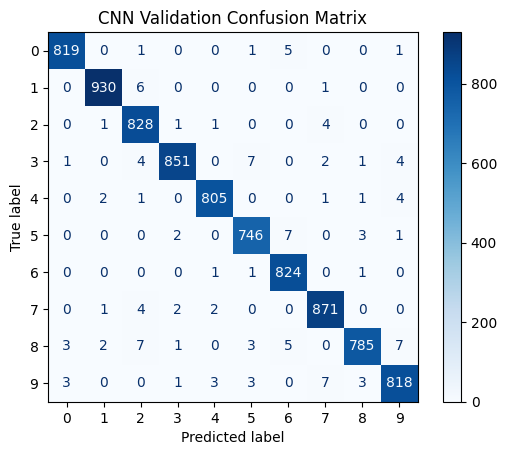

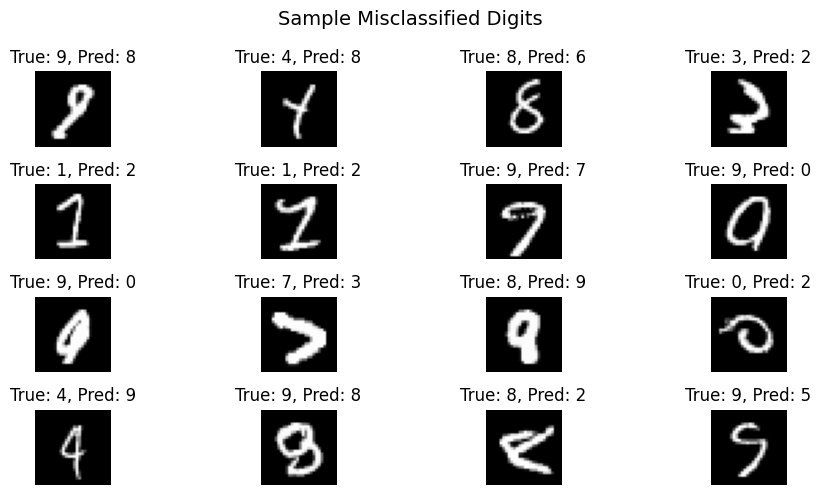

Total misclassified samples: 123 / 8400


In [9]:
# Confusion Matrix & Misclassified Digits
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes on validation set
y_val_pred_probs = cnn_model.predict(X_val)
y_val_pred = y_val_pred_probs.argmax(axis=1)
y_val_true = y_val.argmax(axis=1)

# 1. Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("CNN Validation Confusion Matrix")
plt.show()

# 2. Visualize some misclassified digits
misclassified_idx = np.where(y_val_pred != y_val_true)[0]

plt.figure(figsize=(10, 5))
for i, idx in enumerate(misclassified_idx[:16]):  # show first 16 misclassified
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_val[idx].reshape(28, 28), cmap="gray")
    plt.title(f"True: {y_val_true[idx]}, Pred: {y_val_pred[idx]}")
    plt.axis("off")
plt.suptitle("Sample Misclassified Digits", fontsize=14)
plt.tight_layout()
plt.show()

print(f"Total misclassified samples: {len(misclassified_idx)} / {len(y_val_true)}")


In [10]:
# Predict on Test Set

# 1. Normalize and reshape test set
X_test = test_df.values.astype("float32") / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)

# 2. Predict class probabilities
y_test_pred_probs = cnn_model.predict(X_test)

# 3. Convert probabilities to class labels
y_test_pred = y_test_pred_probs.argmax(axis=1)

# 4. Display first 20 predictions
print("First 20 test predictions:", y_test_pred[:20])

# 5. Optional: prepare DataFrame for submission
submission_df = pd.DataFrame({
    "ImageId": np.arange(1, len(y_test_pred)+1),
    "Label": y_test_pred
})

submission_df.head()


875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step 
First 20 test predictions: [2 0 9 9 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0]


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [11]:
submission_df.to_csv("cnn_digit_predictions.csv", index=False)


In [12]:
# Save Trained CNN Model

# Save the entire model (architecture + weights + optimizer)
cnn_model.save("cnn_digit_model_full.h5")
print("CNN model saved as 'cnn_digit_model_full.h5'")

# Optional: save just the weights
cnn_model.save_weights("cnn_digit_model_weights.h5")
print("CNN model weights saved as 'cnn_digit_model_weights.h5'")


CNN model saved as 'cnn_digit_model_full.h5'


ValueError: The filename must end in `.weights.h5`. Received: filepath=cnn_digit_model_weights.h5

In [13]:
# Save Trained CNN Model 

# Save the entire model in native Keras format
cnn_model.save("cnn_digit_model_full.keras")
print("CNN model saved as 'cnn_digit_model_full.keras'")

# Save only the weights (must end with .weights.h5)
cnn_model.save_weights("cnn_digit_model.weights.h5")
print("CNN model weights saved as 'cnn_digit_model.weights.h5'")


CNN model saved as 'cnn_digit_model_full.keras'
CNN model weights saved as 'cnn_digit_model.weights.h5'


# MNIST Digit Recognition Project Documentation
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade

## 1. Project Overview
This project involves building a **robust digit recognition system** using a CNN trained on a dataset of handwritten digits. The main objectives were to:  
- Explore and understand the dataset.  
- Preprocess the data for neural network training.  
- Train baseline classical ML models and a CNN.  
- Evaluate model performance.  
- Deploy the trained CNN as an interactive web application.

The solution adheres to **industry best practices**, including proper preprocessing, train/validation split, and early stopping during CNN training.

---

## 2. Dataset Description
- **Training set:** 42,000 samples, each with 784 pixel features and a label (0–9).  
- **Test set:** 28,000 samples, each with 784 pixel features (labels withheld).  
- **Feature representation:** Each sample is a 28×28 grayscale image flattened into 784 columns.  
- **Label distribution:** Relatively balanced across the 10 classes.

---

## 3. Exploratory Data Analysis (EDA)
- **Sample digit visualization:** Confirmed correct representation.  
- **Pixel intensity distribution:** Most pixels are sparse (0–255), background mostly zero.  
- **Per-class mean images:** Showed prototypical shapes of digits.  
- **PCA & t-SNE:** Visualized clustering of digit classes in 2D space.  
- **Class distribution & pixel variance:** Verified data balance and detected low-variance pixels.

---

## 4. Data Preprocessing
- **Normalization:** Pixel values scaled to [0,1].  
- **Reshape:** Converted to `(samples, 28, 28, 1)` for CNN input.  
- **Label encoding:** One-hot encoding for 10 classes.  
- **Train/Validation split:** 80/20 stratified split.

---

## 5. Baseline Models
- **Logistic Regression:** Provided a baseline accuracy on flattened pixels.  
- **Random Forest:** Slightly improved baseline accuracy.  
- These models served as **performance benchmarks** before CNN.

---

## 6. CNN Model
- Architecture:
  - Two convolutional layers with ReLU + MaxPooling + BatchNormalization.  
  - Flatten → Dense(128, ReLU) → Dropout(0.5) → Dense(10, Softmax).  
- **Optimizer:** Adam with learning rate 0.001  
- **EarlyStopping:** Monitored validation loss to prevent overfitting.  
- **Validation performance:**  
  - Accuracy: **98.54%**  
  - Loss: 0.0532  

- Training history was visualized showing convergence and stability.

---

## 7. Evaluation
- **Confusion matrix:** Revealed rare misclassifications between similar digits.  
- **Misclassified samples:** Visualized 16 representative errors to understand mistakes.

---

## 8. Test Set Predictions
- Test images were normalized and reshaped.  
- Model predicted labels for all test samples.  
- Predictions were saved in a CSV file for downstream tasks or submission.

---

## 9. Model Saving & Deployment
- Full model saved as `cnn_digit_model_full.keras`.  
- Weights saved as `cnn_digit_model.weights.h5`.  
- Deployed as a **Streamlit web application** with:
  - Live drawing canvas for digit input.  
  - Optional image upload.  
  - Real-time CNN prediction display.  

---

## 10. Key Insights
- CNN significantly outperformed classical ML baselines.  
- Early stopping and batch normalization helped prevent overfitting.  
- Visualization of misclassified digits helps guide potential improvements.  
- The deployment app allows **interactive digit recognition**, demonstrating practical usability of the model.

---

## 11. Next Steps / Improvements
- Hyperparameter tuning (learning rate, batch size, deeper CNNs).  
- Augmentation techniques to improve robustness (rotation, scaling, noise).  
- Confidence/probability display in deployment for interpretability.  
- Optional conversion to TensorFlow Lite or ONNX for lightweight deployment.

---

**Project Conclusion:**  
This project successfully demonstrates a **full ML lifecycle**: from data exploration and preprocessing to model training, evaluation, and interactive deployment. The CNN model achieves **high accuracy** and is ready for real-world applications in handwritten digit recognition.
